In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
!pip install py7zr > /dev/null
import requests
import os
import zipfile
import py7zr
import warnings
warnings.filterwarnings('ignore')

In [3]:
REPO_URL="https://raw.githubusercontent.com/sinc-lab/rna-llm-folding/refs/heads/main"
DATA_PATH=f"{REPO_URL}/data"
RESULTS_PATH=f"{REPO_URL}/results"

In [4]:
llm_colors={'RNA-FM': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
            'RiNALMo': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
            'RNABERT': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
            'RNAErnie': (0.8392156862745098,  0.15294117647058825,  0.1568627450980392,  1.0),
            'one-hot': 'lightgrey',  # (0,0,0, 1),
            'ERNIE-RNA': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
            'RNA-MSM': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
           }

# Read F1 scores

In [5]:
famfold_df = pd.read_csv(f"{RESULTS_PATH}/ArchiveII_famfold/all_famfold.csv")
results = []
llm_names = famfold_df['LLM'].unique()
for llm in llm_names:
    results.append(famfold_df[famfold_df['LLM'] == llm].values.tolist())

In [6]:
# methods = [rinalmo_famfold,
#            rnaernie_famfold,
#            onehot_famfold,
#            rnafm_famfold,
#            rnabert_famfold,
#            rnamsm_famfold,
#            ernierna_famfold]

f1_data = dict()
for method in results:
  for f1, name, family in method:

    if family not in f1_data.keys():
      f1_data[family] = dict()

    if name not in f1_data[family].keys():
      f1_data[family][name] = []

    f1_data[family][name].append(f1)


# Read per-family sequence length

In [7]:
df = pd.read_csv(f'{DATA_PATH}/ArchiveII.csv', header=0)

In [8]:
df['family'] = df['id'].str.split('_', expand=True)[0]
df.loc[:,['family','len']]

length = dict()
for fam in set(df.family):
  length[fam] = df.loc[df.family==fam, 'len'].values

# Read train partition structure distance

In [9]:
def download_and_uncompress_7z(url):
  response = requests.get(url)
  response.raise_for_status()

  temp_dir = os.path.join(os.getcwd(), "temp")
  os.makedirs(temp_dir, exist_ok=True)

  temp_7z_file = os.path.join(temp_dir, "temp.7z")
  with open(temp_7z_file, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
      if chunk:
        f.write(chunk)

  with py7zr.SevenZipFile(temp_7z_file, "r") as zip_ref:
    zip_ref.extractall(os.getcwd())
  os.remove(temp_7z_file)
  os.rmdir(temp_dir)

In [10]:
download_and_uncompress_7z("https://github.com/sinc-lab/rna-llm-folding/raw/refs/heads/main/data/ArchiveII_rnadist_f_all.7z")
# download_and_uncompress_7z("https://github.com/sinc-lab/rna-llm-folding/raw/refs/heads/main/data/ArchiveII_seqsim_f_all.7z")
rnadist = pd.read_hdf(f"ArchiveII_rnadist_f_all.h5")
#rnadist = pd.read_hdf(f"ArchiveII_seqsim_f_all.h5")

family_by_seq = np.array([f.split('_')[0] for f in rnadist.columns.to_list()])

unique_families = np.unique(family_by_seq)

distance = dict()
for fam in unique_families:
  idx_family = np.where(family_by_seq==fam)[0]
  idx_not_family = np.where(family_by_seq!=fam)[0]

  # min distance to train
  distance[fam] = rnadist.iloc[idx_family, idx_not_family].values.min(axis=1)

  # max similarity to train
  #distance[fam] = rnadist.iloc[idx_family, idx_not_family].values.max(axis=1)

# Read baseline scores

In [11]:
famfold_df = pd.read_csv(f"{RESULTS_PATH}/ArchiveII_famfold/baseline_scores.csv")
medians = famfold_df.groupby('fam').median()
medians

,F1
fam,
16s,0.658618
23s,0.692308
5s,0.783784
RNaseP,0.578431
grp1,0.611402
srp,0.680000
tRNA,0.755556
telomerase,0.506024
tmRNA,0.378078


# Plot

In [12]:
def boxplot_kde(family='5s', K=60, palette='red'):

  tam_w = 5.5 # fig width
  tam_h = 5.5 # fig height

  #===================================================
  # KMEANS
  from sklearn.cluster import KMeans
  import matplotlib
  matplotlib.rc('axes', edgecolor='gray')


  #===================================================
  # SORT METHOD BY MEDIAN
  method = []
  median = np.zeros(len(f1_data[family].keys()))

  for i,m in enumerate(f1_data[family].keys()):
    method.append(m)
    median[i] = np.median(f1_data[family][m])

  methods = [method[i] for i in median.argsort()[::-1]]

  colors = [llm_colors[m] for m in methods]
  #===================================================


  #===================================================
  # EXTRACT F1 VALUES BY METHOD
  f1 = []
  f1_swarm = []
  for method in methods:

    f1_values = np.array(f1_data[family][method])

    f1.append(f1_values)

    if len(f1_values) > K:
      kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto").fit(f1_values.reshape(-1,1))
      f1_swarm.append(kmeans.cluster_centers_)
    else:
      f1_swarm.append(f1_values)


  f1 = np.array(f1).T
  f1_swarm = np.array(f1_swarm).squeeze().T

  #====================
  fig,ax = plt.subplots(1, 1, figsize=(tam_w/2.54, tam_h/2.54))
  plt.rcParams.update({'font.size': 5})
  sns.set_style("whitegrid")

  ax.remove()
  ax1 = plt.subplot2grid((3,2), (0,0), colspan=2, rowspan=2, fig=fig)
  ax2 = plt.subplot2grid((3,2), (2,0), rowspan=1, fig=fig)
  ax3 = plt.subplot2grid((3,2), (2,1), rowspan=1, fig=fig)
  #====================

  FS_labels = 6
  FS_ticks = 5
  #==========================
  # BOXPLOT
  #=========
  sns.boxplot(f1, ax=ax1, boxprops=dict(alpha=.5), fill=False, linewidth=0.75, whis=10, palette=colors)
  sns.swarmplot(f1_swarm, size=1.05, ax=ax1, alpha=1., palette=colors)

  ax1.set_ylabel('F1 score', fontsize=FS_labels)
  ax1.set_xlabel('')
  ax1.set_xticks(range(len(f1_data[family].keys())))
  ax1.tick_params(axis='x', pad=0)
  ax1.tick_params(axis='y', pad=0)
  ax1.set_xticklabels([f'{method}' for method in methods], fontsize=FS_ticks, rotation=45)
  ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=FS_ticks)
  ax1.grid(True, axis='y')
  ax1.set_ylim([0, 1])

  ax1.axhline(medians.loc[fam, 'F1'], 0, 1, color=(0/255, 128/255, 255/255), linewidth=0.75)

  #==========================
  # length
  #==========
  COLOR = (0/255, 128/255, 255/255)

  f = sns.kdeplot(length[family], fill=True, color=COLOR, alpha=0.15, ax=ax2, linewidth=1.)
  ax2.set_xlabel('Sequence length', fontsize=FS_labels)
  ax2.set_ylabel('')
  ax2.set_xlim([0,600])
  ax2.set_ylim([0, f.get_ylim()[1]*1.01])

  ax2.set(yticks=[])

  ax2.tick_params(axis='x', pad=0)

  ax2.xaxis.set_ticks([0,300,600],[0,300,600],fontsize=FS_ticks)
  ax2.grid(False)

  ax2.text(0.9, 0.8, f'N = {length[family].shape[0]}', fontsize=FS_ticks, transform=ax2.transAxes, va='top', ha='right', color=COLOR)  # bbox=dict(facecolor=COLOR, alpha=0.5))
  #==========================


  #==========================
  # distance
  #============
  COLOR = (243/255, 111/255, 0/255)

  sns.kdeplot(distance[family], color=COLOR, fill=True, alpha=0.15, ax=ax3, linewidth=1.)
  ax3.set_ylabel('')
  ax3.set(yticks=[])

  ax3.tick_params(axis='x', pad=0)

  # DISTANCE
  ax3.set_xlabel('Distance', fontsize=FS_labels)
  ax3.set_xlim([0,1])
  ax3.xaxis.set_ticks([0,0.5,1],[0,0.5,1],fontsize=FS_ticks)


  # SIMILARITY
  #ax3.set_xlim([0,1])
  #ax3.xaxis.set_ticks([0,0.5,1],[0,0.5,1],fontsize=FS_ticks)
  #ax3.set_xticklabels([0,0.5,1],fontsize=FS_ticks)
  #ax3.set_xlabel('Similarity', fontsize=FS_labels)

  ax3.grid(False)
  #==========================

  plt.tight_layout();

  plt.savefig(f'fig3_{family}.svg', dpi=600)
  plt.savefig(f'fig3_{family}.pdf', dpi=600)

# 5s

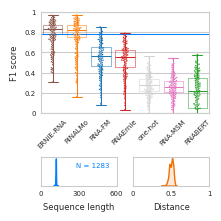

In [13]:
fam = '5s'
boxplot_kde(family=fam, K=100, palette=llm_colors)

# 16s



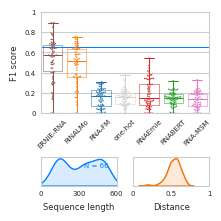

In [14]:
fam = '16s'
boxplot_kde(family=fam, K=100, palette=llm_colors)

#  23s

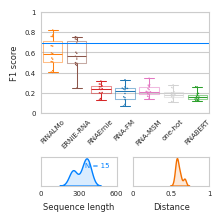

In [15]:
fam = '23s'
boxplot_kde(family=fam, K=100, palette=llm_colors)

# RNaseP

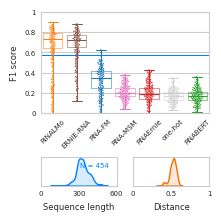

In [16]:
fam = 'RNaseP'
boxplot_kde(family=fam, K=100, palette=llm_colors)

# grp1

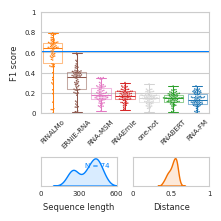

In [18]:
fam = 'grp1'
boxplot_kde(family=fam, K=100, palette=llm_colors)

# srp

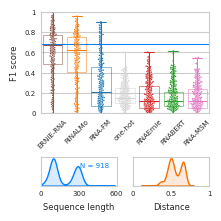

In [19]:
fam = 'srp'
boxplot_kde(family=fam, K=150, palette=llm_colors)

# tRNA

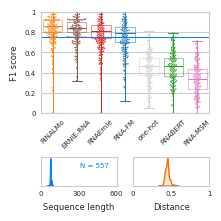

In [20]:
fam = 'tRNA'
boxplot_kde(family=fam, K=120, palette=llm_colors)

# Telomerase

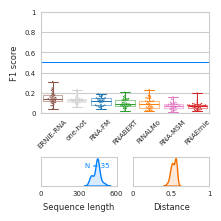

In [21]:
fam = 'telomerase'
boxplot_kde(family=fam, K=120, palette=llm_colors)

# tmRNA

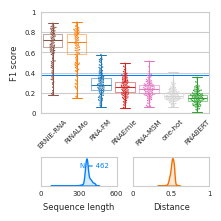

In [22]:
fam = 'tmRNA'
boxplot_kde(family=fam, K=90, palette=llm_colors)